# **Activity Recognition with Machine Learning**

This notebook implements two 1D convolutional neural networks (CNN), one for recognising physical activities and the other for recognising social signals. The dataset the models are trained on includes multiple 30-second recordings of various physical activities (e.g., ascending stairs, shuffle walking, sitting-standing) and social signals (e.g. coughing, hyperventilating) stored in separate CSV files. These recordings were made using a wearable Respeck device which contains a linear accelerometer, measuring linear acceleration, and a gyroscope which measures angular velocity. The device is placed on the lower left ribcage. The models developed here are deployed inside an Android application for live classification.


# Imports

In [12]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow as tf

# Reading Files
This section reads files from the dataset.

In [13]:
# Print the current working directory
print(os.getcwd())

c:\Users\seanc\OneDrive - University of Edinburgh\Semester 1\PDIOT\CW3\ML Model


In [14]:
# Path to Respeck sensor data
your_dataset_path = "./PDIoT2324/Respeck/"

This line uses the glob module to find all file paths that match a specified pattern. The 'glob.glob()' function returns a list of file paths that match the given pattern.

The `*` is a wildcard character that matches any string of characters, so this pattern retrieves all files in the directory.

In [15]:
glob.glob(your_dataset_path + "/*")

['./PDIoT2324/Respeck\\00_Respeck_Descending stairs_Normal.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Coughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Hyperventilating.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Laughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Normal.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Singing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Talking.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Coughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Hyperventilating.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Laughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Normal.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Singing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Talking.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on stomach_Coughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on stomach_Hy

# Functions
This section defines the functions used throughout the notebook to preprocess the data and develop the CNN models. 

In [16]:
# Define the activities and social signals to be classified, with appropriate labels
activities = {
    'ascending': 0,
    'shuffleWalking': 1,
    'sittingStanding': 2,
    'miscMovement': 3,
    'normalWalking': 4,
    'lyingBack': 5,
    'lyingLeft': 6,
    'lyingRight': 7,
    'lyingStomach': 8,
    'descending': 9,
    'running': 10
}

social_signals = {
    'breathingNormal': 0,
    'coughing': 1,
    'hyperventilating': 2,
    'other': 3
}


activity_labels = list(activities.keys())
social_signal_labels = list(social_signals.keys())

In [17]:
def load_files_from_folder(folder_path):
    """
    Load all CSV files from a folder and return a list of file paths.

    Parameters:
    folder_path (str): The path to the folder containing CSV files.

    Returns:
    file_paths (list): A list of file paths for all CSV files in the folder.
    """

    # Initialize an empty list to store the full file paths of the CSV files
    file_paths = []

    # Loop through all the files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file has a .csv extension (ignores other files)
        if file_name.endswith('.csv'):
            # Construct the full file path by joining the folder path and the file name
            full_file_path = os.path.join(folder_path, file_name)

            # Append the full file path to the file_paths list
            file_paths.append(full_file_path)

    # Return the complete list of CSV file paths
    return file_paths

In [18]:
def extract_task(file_name, task):
    """
    Extract the activity or social signal label from a file name.

    Parameters:
    file_name (str): The name of the file containing the label.
    task (str): The task to extract from the file name (e.g., 'activity' or 'social_signal').

    Returns:
    label (str): The extracted label from the file name.
    """

    # Split the file name by underscores to extract different parts
    file_parts = file_name.split('_')

    # Check if the task is 'activity'
    if task == 'activity':
        # The activity label is the second part of the file name
        label = file_parts[2]
    # Check if the task is 'social_signal'
    elif task == 'social_signal':
        # The social signal label is the third part of the file name
        label = file_parts[3].split(".")[0]

    if label == "sitting" or label == "standing" or label == "Sitting" or label == "Standing":
        label = "sittingStanding"
    
    # For processing the 2024_2025 dataset which has different naming
    if label == "Descending stairs":
        label = "descending"
    
    if label == "Ascending stairs":
        label = "ascending"
    
    if label == "Lying down back":
        label = "lyingBack"
    
    if label == "Lying down on left":
        label = "lyingLeft"
    
    if label == "Lying down on stomach":
        label = "lyingStomach"
    
    if label == "Lying down right":
        label = "lyingRight"

    if label == "Miscellaneous movements":
        label = "miscMovement"

    if label == "Normal walking":
        label = "normalWalking"

    if label == "Running":
        label = "running"

    if label == "Shuffle walking":
        label = "shuffleWalking"

    if label == "Normal":
        label = "breathingNormal"
    
    if label == "Hyperventilating":
        label = "hyperventilating"

    if label == "Coughing":
        label = "coughing"

    if label == "laughing" or label == "talking" or label == "eating" or label == "singing" or label == "Laughing" or label == "Talking" or label == "Eating" or label == "Singing":
        label = "other"

    if task == "activity":
        label = activities[label]
    else:
        label = social_signals[label]
    # Return the extracted label
    return label

## Sliding Window

In time series Activity Recognition, a sliding window is a commonly used technique to segment continuous sensor data (such as accelerometer readings) into smaller, fixed-length overlapping or non-overlapping time intervals, or windows. Each window contains a sequence of sensor measurements that represent a short period of time, and this segmented data is used to extract features or make predictions about the activity happening within that window.

### Key Concepts of a Sliding Window
1.   **Window Size:** This refers to the length of each segment or window, typically defined in terms of the number of time steps or the duration (e.g., 2 seconds). The window size is chosen carefully to be 100 for both the activity and social signal classification models, aiming to capture enough information about the task without the window being too large. .
2.   **Step Size:** The step size determines how far the window moves forward after each step. If the step size is smaller than the window size, the windows will overlap. For example, if the window size is 5 seconds and the step size is 2 seconds, there will be a 3-second overlap between consecutive windows. Overlapping windows provide more data for analysis and can help smooth out predictions by capturing transitional activities. The step size is chosen to be 10 for the social signal classification model and 20 for the activity classification model.
3.   **Non-Overlapping Windows:** If the step size is equal to the window size, the windows do not overlap. This method provides distinct segments of data but may miss transitional phases between activities.

### Why Sliding Windows for Activity Recognition?

* Segmentation of Continuous Data: Activity recognition systems work with continuous streams of sensor data, and the sliding window helps segment these into manageable pieces to classify activities within specific intervals.

* Context Capturing: Human activities are often complex and spread across time. By using a sliding window, you can capture context across a short duration, which may include transitions or small fluctuations in the activity (e.g., a person moving from sitting to standing).

* Feature Extraction: Within each window, features such as mean, variance, frequency domain features, etc., can be extracted to help classify the activity.

* Real-Time Recognition: In real-time systems, the sliding window allows for continuous monitoring and updating of predictions as new data arrives.



In [20]:
def load_and_apply_sliding_windows(file_paths, window_size, step_size, task):
    """
    Load the data from each file, apply sliding windows, and return the windows and labels.

    Parameters:
    file_paths (list): List of file paths to CSV files. Each file contains sensor data (e.g., accelerometer, gyroscope).
    window_size (int): The size of each sliding window (number of time steps).
    step_size (int): The step size (stride) between consecutive windows.
    task (str): Either "activity" or "social_signal" to specify the type of task for classification.	

    Returns:
    tuple:
        - windows (numpy.ndarray): A 3D array of sliding windows, where each window has the shape
                                   (num_windows, window_size, num_features).
        - labels (numpy.ndarray): A 1D array of labels, where each label corresponds to a sliding window.
    """
    # Initialise lists to store sliding windows and their corresponding labels
    windows = []
    labels = []

    # Loop through each file in the provided file paths
    for file_path in file_paths:
        label = extract_task(file_path, task)
        # Load the CSV file into a pandas DataFrame
        data = pd.read_csv(file_path)

        # Select the columns containing the necessary sensor data (acceleration readings)
        data = data[['accel_x', 'accel_y', 'accel_z']]

        # Convert the DataFrame into a numpy array for faster processing in the sliding window operation
        data = data.to_numpy()

        # Get the number of samples (rows) and features (columns) in the data
        num_samples, _ = data.shape

        # Apply sliding windows to the data
        # The range function defines the start of each window, moving step_size increments at a time
        for i in range(0, num_samples - window_size + 1, step_size):
            # Extract a window of size 'window_size' from the current position 'i'
            window = data[i:i + window_size, :]

            # Append the window to the windows list
            windows.append(window)

            # Assign the activity label to the window and append it to the labels list
            labels.append(label)

    # Convert the lists of windows and labels into numpy arrays for efficient numerical operations
    return np.array(windows), np.array(labels)

In [21]:
def process_task(task, dataset_path, window_size, step_size):
    """
    This function loads the CSV files from the directory, applies the sliding windows and labels the windows with the corresponding activity or social signal. 
    This function can be used repeatedly for each activity to process and prepare data for training and evaluation.

    Args:
        task (str): The task to process, either 'activity' or 'social_signal'.
        dataset_path (str): The path to the dataset folder.
        window_size (int): The size of each sliding window (number of time steps).
        step_size (int): The step size between consecutive windows.

    Returns:
        tuple:
            - windows (numpy.ndarray): A 3D array of sliding windows, where each window has the shape
                                       (num_windows, window_size, num_features).
            - labels (numpy.ndarray): A 1D array of labels, where each label corresponds to a sliding window.
    """

    # Load all CSV file paths for the given activity from the folder
    file_list = load_files_from_folder(dataset_path)
    
    # Apply sliding windows 
    # The function 'load_and_apply_sliding_windows' returns the sliding windows (segments) and their corresponding labels
    windows, labels = load_and_apply_sliding_windows(file_list, window_size, step_size, task)

    # Return the sliding windows and their labels
    return windows, labels

## 1D CNN Model

This function, `build_1d_cnn_model`, creates and compiles a 1D Convolutional Neural Network (CNN) for multi-class classification tasks.

### Function Overview

Input Parameters
* `input_shape`: Specifies the shape of the input data. It represents (timesteps, features), where timesteps refer to the length of the time series (e.g., 50 windows), and features represent the number of measurements in each time step (e.g., accelerometer readings).
* `num_classes`: The number of output classes for the classification problem. For example, if you're classifying six different activities, num_classes would be 6.

Returns
* The function returns a compiled 1D CNN model that is ready to be trained on your data.

<hr>

### Function Breakdown
1.   Model Initialization:
     * `model = Sequential()`: Initializes a Sequential model, which means layers will be stacked on top of each other in a linear fashion.
2.   First Convolutional Layer:
     * `Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)`
        * This is the first 1D convolutional layer
        * `filters=64`: The layer applies 64 filters (or kernels) over the input data.
        * `kernel_size=3`: Each filter will cover 3 timesteps at a time (a window of 3).
        * `activation='relu'`: The Rectified Linear Unit (ReLU) activation function introduces non-linearity and helps the model learn complex patterns.
        * `input_shape=input_shape`: Specifies the shape of the input data.
     * `MaxPooling1D(pool_size=2)`: This pooling layer reduces the dimensionality of the data by taking the maximum value from each 2-timestep window (`pool_size=2`). This helps reduce computational complexity and captures the most important features.
3. Second Convolutional Layer:
    * `Conv1D(filters=128, kernel_size=3, activation='relu')`
        * This is the second convolutional layer, similar to the first, but with 128 filters, which allow the network to learn more complex features from the data.
        * `kernel_size=3` and activation='relu' function in the same way as the first Conv1D layer.
    * `MaxPooling1D(pool_size=2)`: Another pooling layer to downsample the output, further reducing the data’s dimensionality.
5. Third Convolutional Layer:
     * `Conv1D(filters=256, kernel_size=3, activation='relu')`
        * Similar to the first two convolutional layers, but with 256 filters.

6. Flattening Layer:
    * `Flattening`: Converts the 2D output of the convolutional and pooling layers into a 1D vector. This is necessary because the next layer is fully connected, and it requires a 1D input.
7. Fully Connected Layer:
    * `Dense(128, activation='relu')`: This is a fully connected layer with 128 units/neurons. Each neuron is connected to every input from the flattened output. The ReLU activation function is used again to introduce non-linearity and help the model learn complex relationships.
8. Dropout Layer:
    * `Dropout(0.3)`: This layer randomly sets 30% of the neurons to zero during training to prevent overfitting. It helps the model generalize better to unseen data.
9. Output Layer:
    * `Dense(num_classes, activation='softmax')`: This is the output layer with num_classes neurons, one for each class in the classification problem. The softmax activation function ensures the output values represent probabilities that sum to 1, useful for multi-class classification.
10. Compiling the model
    * model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        * Optimizer: 'adam': Adam is an optimization algorithm that adjusts the learning rate during training to improve performance.
        * Loss: 'categorical_crossentropy': This loss function is used for multi-class classification problems where the target variable is one-hot encoded (i.e., represented as a vector of 0s and 1s).
        * Metrics: ['accuracy']: The accuracy metric is used to evaluate the model’s performance during training and testing.


In [23]:
def build_1d_cnn_model(input_shape, num_classes):
    """
    Builds and compiles a 1D CNN model for multi-class classification.

    Args:
        input_shape (tuple): The shape of the input data (timesteps, features).
        num_classes (int): The number of output classes.

    Returns:
        model (Sequential): Compiled 1D CNN model.
    """
    model = Sequential()

    # First Conv1D layer
    # You can try experimenting with different filters, kernel_size values and activiation functions
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    # Second Conv1D layer
    # You can try experimenting with different filters, kernel_size values and activiation functions
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Third Conv1D layer
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(128, activation='relu'))

    # Dropout layer for regularization
    # You can try experimenting with different dropout rates
    model.add(Dropout(0.3))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #  Prints a detailed summary of the model, showing the layers, their output shapes, and the number of trainable parameters
    model.summary()
    return model

# Classification Pipeline

## Step 1: Prepare and Preprocess the Data

In [26]:
# Create the sliding windows and labels for the activity and social signal tasks
X_activity, y_activity = process_task("activity", your_dataset_path, window_size=100, step_size=20)
X_social_signal, y_social_signal = process_task("social_signal", your_dataset_path, window_size=100, step_size=10)

### One-Hot Encode Labels (for multi-class classification)
Since there are more than two classes in each classification model, the labels must be one-hot encoded, especially since the modes use categorical cross-entropy loss. One-Hot Encoding converts categorical labels into binary vectors (one-hot encoded format). Each class label is represented as a binary vector with 1 for the correct class and 0 for others. This is necessary for training models that use categorical_crossentropy as the loss function, such as a neural network.

In [27]:
# Initialise the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit the OneHotEncoder on the activity and social signal labels and transform them to one-hot encoded format
y_activity_one_hot = encoder.fit_transform(y_activity.reshape(-1, 1))
y_social_signal_one_hot = encoder.fit_transform(y_social_signal.reshape(-1, 1))

In [28]:
# Print the shapes of the one-hot encoded labels to verify that the transformation was successful
print(f"y_activity_one_hot shape: {y_activity_one_hot.shape}")
print(f"y_social_signal_one_hot shape: {y_social_signal_one_hot.shape}")

# Explanation of shapes:
# - The shape of y_activity_one_hot will be (num_samples, num_classes), where:
#     - num_samples is the number of training windows.
#     - num_classes is the number of unique activities (the length of the one-hot vectors).
# - The shape of y_social_signal_one_hot will be (num_samples, num_classes), similar to y_activity_one_hot.

y_activity_one_hot shape: (180248, 11)
y_social_signal_one_hot shape: (356279, 4)


## Step 2: Build the 1D-CNN Model
Call our `build_1d_cnn_model` function to build our models.

In [29]:
# Determine the input shape for the model
input_shape_activity = (X_activity.shape[1], X_activity.shape[2])
print(f"Input shape for the activity model: {input_shape_activity}")

input_shape_social_signal = (X_social_signal.shape[1], X_social_signal.shape[2])
print(f"Input shape for the social signal model: {input_shape_social_signal}")

# Determine the number of output classes (num_classes)
num_activity_classes = y_activity_one_hot.shape[1]
num_social_signal_classes = y_social_signal_one_hot.shape[1]

Input shape for the activity model: (100, 3)
Input shape for the social signal model: (100, 3)


## Step 3: Prepare for 5-fold cross-validation

`model.fit()` is used to train the neural network model. It takes several parameters:
* `X_train_fold`: The input training data (sliding windows) for that particular fold, with shape (num_samples, window_size, num_features).
* `y_train_fold`: The corresponding one-hot encoded labels for the training data for that fold, with shape (num_samples, num_classes).
* `epochs`: Number of times the entire training dataset is passed through the model. 
* `batch_size`: Number of samples processed before the model's weights are updated.
* `validation_data`: This parameter allows us to evaluate the model's performance on the test data after each epoch.
*`(X_val_fold y_val_fold)`: These are the input validation data and corresponding one-hot encoded test labels.

In [30]:
# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialise lists to store the accuracy of each fold
activity_accuracy_list = []
social_signal_accuracy_list = []

# Initialise lists to store the recall for each class for all folds
recall_per_class_per_fold_social_signal = {i: [] for i in range(num_social_signal_classes)}
recall_per_class_per_fold_activity = {i: [] for i in range(num_activity_classes)}

# Initialise lists to store the true and predicted labels for social signals for all folds
all_y_true_social_signal = []
all_y_pred_social_signal = []

# Initialise lists to store the true and predicted labels for activities for all folds
all_y_true_activity = []
all_y_pred_activity = []


In [31]:
fold_no = 1

# Train and Evaluate social signal model
for train_index, val_index in kfold.split(X_social_signal):
    print(f"Training social signal model for fold {fold_no}")

    # Split the data for this fold
    X_train_fold_social_signal, X_val_fold_social_signal = X_social_signal[train_index], X_social_signal[val_index]
    y_train_fold_social_signal, y_val_fold_social_signal = y_social_signal_one_hot[train_index], y_social_signal_one_hot[val_index]

    # Reinitialise the social signal model for each fold
    social_signal_model = build_1d_cnn_model(input_shape_social_signal, num_social_signal_classes)

    history = social_signal_model.fit(X_train_fold_social_signal, y_train_fold_social_signal,
                                        epochs=17, batch_size=64,
                                        validation_data=(X_val_fold_social_signal, y_val_fold_social_signal),
                                        verbose=1)
    
    y_pred_probs_social_signal = social_signal_model.predict(X_val_fold_social_signal)
    y_pred_social_signal = np.argmax(y_pred_probs_social_signal, axis=1)
    y_true_social_signal = np.argmax(y_val_fold_social_signal, axis=1)

    social_signal_report = classification_report(y_true_social_signal, y_pred_social_signal, output_dict=True)
    for i in range(num_social_signal_classes):
        recall_per_class_per_fold_social_signal[i].append(social_signal_report[str(i)]['recall'])

    social_signal_accuracy_list.append(accuracy_score(y_true_social_signal, y_pred_social_signal))

    # Collect predictions and true social signal labels for confusion matrix
    all_y_true_social_signal.extend(y_true_social_signal)
    all_y_pred_social_signal.extend(y_pred_social_signal)

    print(f"Completed training and evaluation for fold {fold_no}")

    # Print recall for each class after each fold
    for i in range(num_social_signal_classes):
        print(f"Recall for class {i} after fold {fold_no}: {recall_per_class_per_fold_social_signal[i][-1]:.4f}")

    fold_no += 1

average_social_signal_accuracy = np.mean(social_signal_accuracy_list)
print(f"Average accuracy for social signal model: {average_social_signal_accuracy:.4f}")

average_recall_per_class_social_signal = {i: np.mean(recall_per_class_per_fold_social_signal[i]) for i in range(num_social_signal_classes)}

for i in range(num_social_signal_classes):
    print(f"The 5-fold cross validation recall of class {i} is {average_recall_per_class_social_signal[i]:.4f}")

Training social signal model for fold 1


c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,228 (1.73 MB)

 Trainable params: 452,228 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.6140 - loss: 0.9114 - val_accuracy: 0.7195 - val_loss: 0.6523
Epoch 2/17
 887/4454 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.7183 - loss: 0.6444

KeyboardInterrupt: 

# Social signal confusion matrix

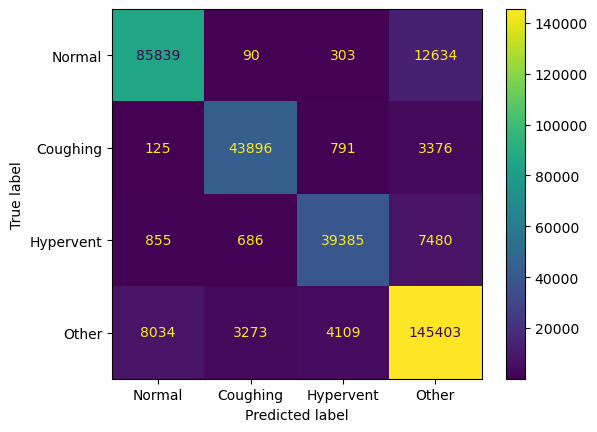

In [74]:
# Convert the lists for the confusion matrix to numpy arrays
all_y_true_social_signal = np.array(all_y_true_social_signal)
all_y_pred_social_signal = np.array(all_y_pred_social_signal)

# Generate confusion matrix
cm = confusion_matrix(all_y_true_social_signal, all_y_pred_social_signal)
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Coughing', 'Hypervent', 'Other']).plot()

In [75]:
# Train and Evaluate activity model using 5-fold cross validation
fold_no = 1
for train_index, val_index in kfold.split(X_activity):
    print(f"Training activity model for fold {fold_no}")

    # Split the data for this fold
    X_train_fold_activity, X_val_fold_activity = X_activity[train_index], X_activity[val_index]
    y_train_fold_activity, y_val_fold_activity = y_activity_one_hot[train_index], y_activity_one_hot[val_index]

    # Reinitialise the activity model for each fold
    activity_model = build_1d_cnn_model(input_shape_activity, num_activity_classes)

    history = activity_model.fit(X_train_fold_activity, y_train_fold_activity, 
                                 epochs=15, batch_size=64, 
                                 validation_data=(X_val_fold_activity, y_val_fold_activity), 
                                 verbose=1)
    
    # Predictions and evaluation for activity model
    y_pred_probs_activity = activity_model.predict(X_val_fold_activity)
    y_pred_activity = np.argmax(y_pred_probs_activity, axis=1)
    y_true_activity = np.argmax(y_val_fold_activity, axis=1)

    activity_report = classification_report(y_true_activity, y_pred_activity, output_dict=True)
    for i in range(num_activity_classes):
        recall_per_class_per_fold_activity[i].append(activity_report[str(i)]['recall'])
    activity_accuracy_list.append(accuracy_score(y_true_activity, y_pred_activity))

    # Collect predictions and true social signal labels for confusion matrix
    all_y_true_activity.extend(y_true_activity)
    all_y_pred_activity.extend(y_pred_activity)

    print(f"Completed training and evaluation for fold {fold_no}")

     # Print recall for each class after each fold
    for i in range(num_activity_classes):
        print(f"Recall for class {i} after fold {fold_no}: {recall_per_class_per_fold_activity[i][-1]:.4f}")
    fold_no += 1
    
average_activity_accuracy = np.mean(activity_accuracy_list)
print(f"Average accuracy for activity model: {average_activity_accuracy:.4f}")

average_recall_per_class_activity = {i: np.mean(recall_per_class_per_fold_activity[i]) for i in range(num_activity_classes)}

for i in range(num_activity_classes):
    print(f"The 5-fold cross validation recall of class {i} is {average_recall_per_class_activity[i]:.4f}")

Training activity model for fold 1


c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_75 (Conv1D)              │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - accuracy: 0.8830 - loss: 0.4356 - val_accuracy: 0.9456 - val_loss: 0.1882
Epoch 2/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9465 - loss: 0.1962 - val_accuracy: 0.9563 - val_loss: 0.1510
Epoch 3/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9559 - loss: 0.1597 - val_accuracy: 0.9643 - val_loss: 0.1221
Epoch 4/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9627 - loss: 0.1321 - val_accuracy: 0.9702 - val_loss: 0.1142
Epoch 5/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9659 - loss: 0.1198 - val_accuracy: 0.9698 - val_loss: 0.1080
Epoch 6/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9697 - loss: 0.1078 - val_accuracy: 0.9742 - val_loss: 0.0925
Epoch 7/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9720 - loss: 0.0982 - val_accuracy: 0.9743 - val_loss: 0.0897
Epoch 8/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9741 -

c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_78 (Conv1D)              │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_78 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_79 (Conv1D)              │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_79 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_80 (Conv1D)              │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.8850 - loss: 0.4297 - val_accuracy: 0.9488 - val_loss: 0.1810
Epoch 2/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.9467 - loss: 0.1957 - val_accuracy: 0.9606 - val_loss: 0.1396
Epoch 3/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9598 - loss: 0.1442 - val_accuracy: 0.9629 - val_loss: 0.1291
Epoch 4/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9648 - loss: 0.1258 - val_accuracy: 0.9681 - val_loss: 0.1135
Epoch 5/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9691 - loss: 0.1117 - val_accuracy: 0.9736 - val_loss: 0.0980
Epoch 6/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9722 - loss: 0.1024 - val_accuracy: 0.9586 - val_loss: 0.1600
Epoch 7/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9732 - loss: 0.0979 - val_accuracy: 0.9753 - val_loss: 0.0870
Epoch 8/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9749 -

c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_81 (Conv1D)              │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_82 (Conv1D)              │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_82 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_83 (MaxPooling1D) │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.8855 - loss: 0.4177 - val_accuracy: 0.9436 - val_loss: 0.1950
Epoch 2/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.9459 - loss: 0.1995 - val_accuracy: 0.9550 - val_loss: 0.1525
Epoch 3/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.9580 - loss: 0.1540 - val_accuracy: 0.9625 - val_loss: 0.1334
Epoch 4/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.9637 - loss: 0.1349 - val_accuracy: 0.9655 - val_loss: 0.1306
Epoch 5/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.9691 - loss: 0.1147 - val_accuracy: 0.9697 - val_loss: 0.1032
Epoch 6/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9715 - loss: 0.1049 - val_accuracy: 0.9720 - val_loss: 0.0965
Epoch 7/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9739 - loss: 0.0932 - val_accuracy: 0.9695 - val_loss: 0.1111
Epoch 8/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9746 -

c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_84 (Conv1D)              │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_84 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_85 (Conv1D)              │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_85 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_86 (Conv1D)              │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_86 (MaxPooling1D) │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.8856 - loss: 0.4188 - val_accuracy: 0.9484 - val_loss: 0.1930
Epoch 2/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 67s 30ms/step - accuracy: 0.9458 - loss: 0.1962 - val_accuracy: 0.9601 - val_loss: 0.1477
Epoch 3/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.9582 - loss: 0.1529 - val_accuracy: 0.9615 - val_loss: 0.1313
Epoch 4/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - accuracy: 0.9636 - loss: 0.1357 - val_accuracy: 0.9667 - val_loss: 0.1147
Epoch 5/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.9694 - loss: 0.1113 - val_accuracy: 0.9706 - val_loss: 0.1094
Epoch 6/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 62s 28ms/step - accuracy: 0.9717 - loss: 0.1036 - val_accuracy: 0.9726 - val_loss: 0.0995
Epoch 7/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 66s 29ms/step - accuracy: 0.9741 - loss: 0.0958 - val_accuracy: 0.9744 - val_loss: 0.0932
Epoch 8/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 65s 29ms/step - accuracy: 0.9744 -

c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_87 (Conv1D)              │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_87 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_88 (Conv1D)              │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_88 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_89 (Conv1D)              │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_89 (MaxPooling1D) │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 168s 71ms/step - accuracy: 0.8821 - loss: 0.4370 - val_accuracy: 0.9449 - val_loss: 0.2065
Epoch 2/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 224s 99ms/step - accuracy: 0.9459 - loss: 0.1982 - val_accuracy: 0.9589 - val_loss: 0.1529
Epoch 3/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 230s 102ms/step - accuracy: 0.9553 - loss: 0.1608 - val_accuracy: 0.9626 - val_loss: 0.1379
Epoch 4/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 133s 59ms/step - accuracy: 0.9631 - loss: 0.1345 - val_accuracy: 0.9570 - val_loss: 0.1557
Epoch 5/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 99s 44ms/step - accuracy: 0.9674 - loss: 0.1164 - val_accuracy: 0.9682 - val_loss: 0.1160
Epoch 6/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 99s 44ms/step - accuracy: 0.9703 - loss: 0.1059 - val_accuracy: 0.9691 - val_loss: 0.1023
Epoch 7/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 93s 41ms/step - accuracy: 0.9724 - loss: 0.0982 - val_accuracy: 0.9703 - val_loss: 0.1131
Epoch 8/15
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 101s 45ms/step - accuracy: 0.

# Confusion matrix for activity model

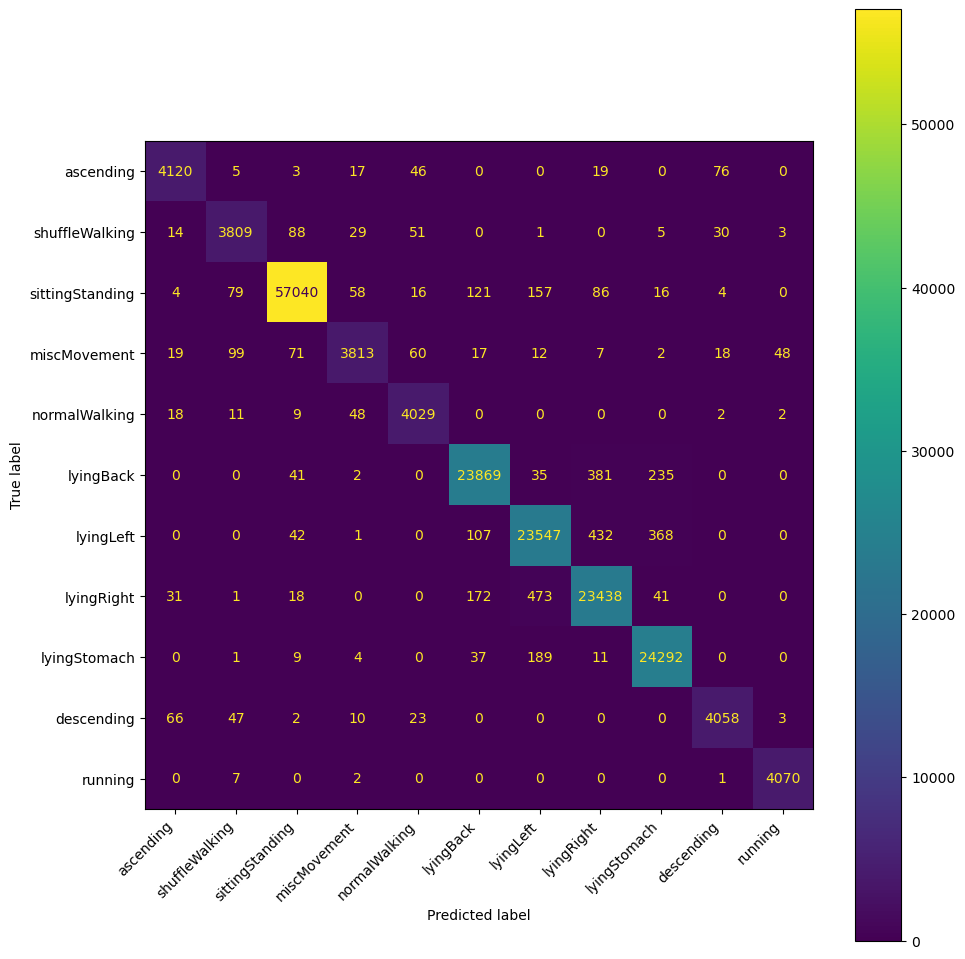

In [76]:
# Convert the lists for the confusion matrix to numpy arrays
all_y_true_activity = np.array(all_y_true_activity)
all_y_pred_activity = np.array(all_y_pred_activity)

# Generate confusion matrix
cm = confusion_matrix(all_y_true_activity, all_y_pred_activity)
disp = ConfusionMatrixDisplay(cm, display_labels=activity_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
disp.plot(ax=ax, cmap='viridis')

# Rotate the x-axis labels and adjust spacing
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Exporting your model to TFLite
The TFLiteConverter class provided by TensorFlow is used to convert the trained models into the TensorFlow Lite format. Models are exported to TensorFlow Lite (TFLite) for several reasons, primarily because TFLite is designed for deployment on edge devices, such as mobile phones, embedded systems, IoT devices, and microcontrollers, where computational resources and power are limited. This is necessary as you will be running your ML models on your Android devices to perform live classification.


In [78]:
# Convert the trained Keras model to TensorFlow Lite format
activity_converter = tf.lite.TFLiteConverter.from_keras_model(activity_model)  # model is your trained Keras model
tflite_activity_model = activity_converter.convert()

social_signal_converter = tf.lite.TFLiteConverter.from_keras_model(social_signal_model)  # model is your trained Keras model
tflite_social_signal_model = social_signal_converter.convert()


# Save the converted model to a .tflite file
with open('activity_model_2.tflite', 'wb') as f:
    f.write(tflite_activity_model)

print("Activity model saved to activity_model.tflite")

with open('social_signal_model_2.tflite', 'wb') as f:
    f.write(tflite_social_signal_model)

print("Social signal model saved to social_signal_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpfb240ptf\assets


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpfb240ptf\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpfb240ptf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_1624')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2410761251024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410761255056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410761252560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410761256592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410761251984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410761251600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410761247952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410761256400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2411878391376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2411878385616: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:t

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpv8mhvpw5\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpv8mhvpw5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_1344')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2411616569872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143503376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143504336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143506256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143507600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143504720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143498768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143502800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143502416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2412143493968: TensorSpec(shape=(), dtype=tf.resource, name=None)
Activit